# Missing values

Many machine learning algorithms and statistical models assume that the data is complete and cannot directly handle missing values. Attempting to train a model on a data set with missing values ​​can lead to errors or unreliable results. Therefore, it is important to fill in the missing data before performing any modeling or analysis tasks. However, filling in missing data carries certain risks. Poorly chosen imputation methods can introduce artificial patterns or distortions into the data set, which in turn can lead to erroneous conclusions or inadequate model predictions. There is a risk that the filled values ​​will not reflect the true relationships between variables, especially when the missingness mechanism is not random. Furthermore, some imputation techniques can underestimate the variance of the data, which can result in overconfidence in estimates and overly narrow confidence intervals. When there are large numbers of missing values, data filling can lead to overreliance on estimates rather than on the actual observations. Therefore, it is essential to carefully consider the imputation method, understand its assumptions and potential impact on the analysis, and conduct sensitivity analyses to assess the impact of imputation on the final results.

The presence of missing values ​​can also affect the representativeness of a data set. If missing data are not randomly distributed and are associated with certain variables or outcomes, they can introduce bias. For example, if
people with certain characteristics are more likely to be missing, excluding them from the analysis can lead to an unrepresentative sample and biased conclusions. Furthermore, missing data can affect the statistical power and precision of analyses. If there are a significant number of missing values, it reduces the effective sample size and can reduce the ability to detect significant relationships or differences in the data. This can lead to
less reliable results and potentially miss important findings.

Dealing with missing values ​​allows you to make full use of your data and draw conclusions. Using appropriate imputation techniques, you can estimate missing values ​​based on patterns and relationships in the observed data. This helps maintain the integrity of the dataset and enables more accurate and reliable analyses.

In [1]:
import pandas as pd
from pathlib import Path
import missingno as msno
from pyampute.exploration.mcar_statistical_tests import MCARTest
import scipy.stats as stats

In [2]:
# Construct the path to the pickled DataFrame
data_path = Path("../data/processed/processed_data.pkl")

# Load the DataFrame
df = pd.read_pickle(data_path)

In [3]:
cols_to_check = ['gvl', 'gvlquant', 'pvl', 'pvlquant', 'trich', 'bv', 'sy', 'ct', 'gc']
df = df.dropna(subset=cols_to_check, how='all')

date_columns = df.select_dtypes(include=['datetime64']).columns
df.drop(columns=date_columns, inplace=True)

<Axes: >

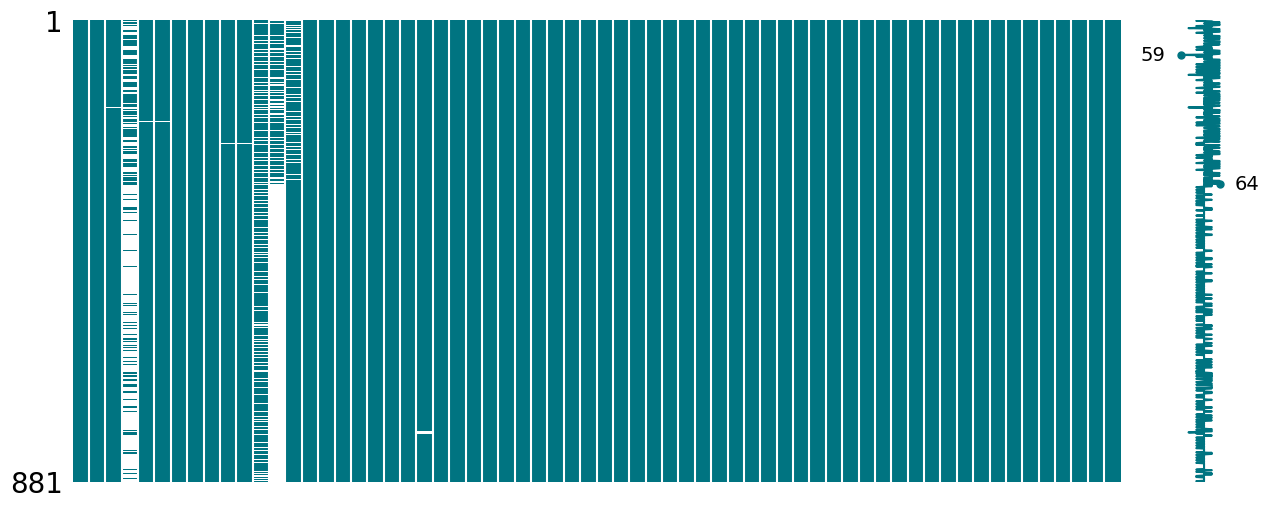

In [4]:
msno.matrix(df, figsize=(15, 6), color=(0, 116/255, 129/255))

The visualization is a plot generated by the msno.matrix function. This visualization provides a more detailed view of missing data patterns across the entire data set. Each row represents an observation, and each column represents a variable. Color
indicates the presence of data, and white spaces indicate missing data.
The plot below allows you to see the distribution of missing data within each variable and across observations. For example, you can determine whether missing data is randomly distributed or whether there are patterns. You can also see whether there are rows with a large number of missing values ​​that may represent outliers or special cases in the data set. By examining the plot, you can identify variables with a large percentage of missing data that may require special attention during the data cleaning and imputation process. You can also see whether missing data is systematic or random, which can determine which imputation method to use or whether certain observations should be excluded from the analysis.
From the graph, it can be concluded that the variables that have significant missing data are ‘qlvquant’, ‘hbg’ and ‘cd4’. I consider all these variables valuable in the next steps of the analysis, so I decide to investigate these missing data further.

<Axes: >

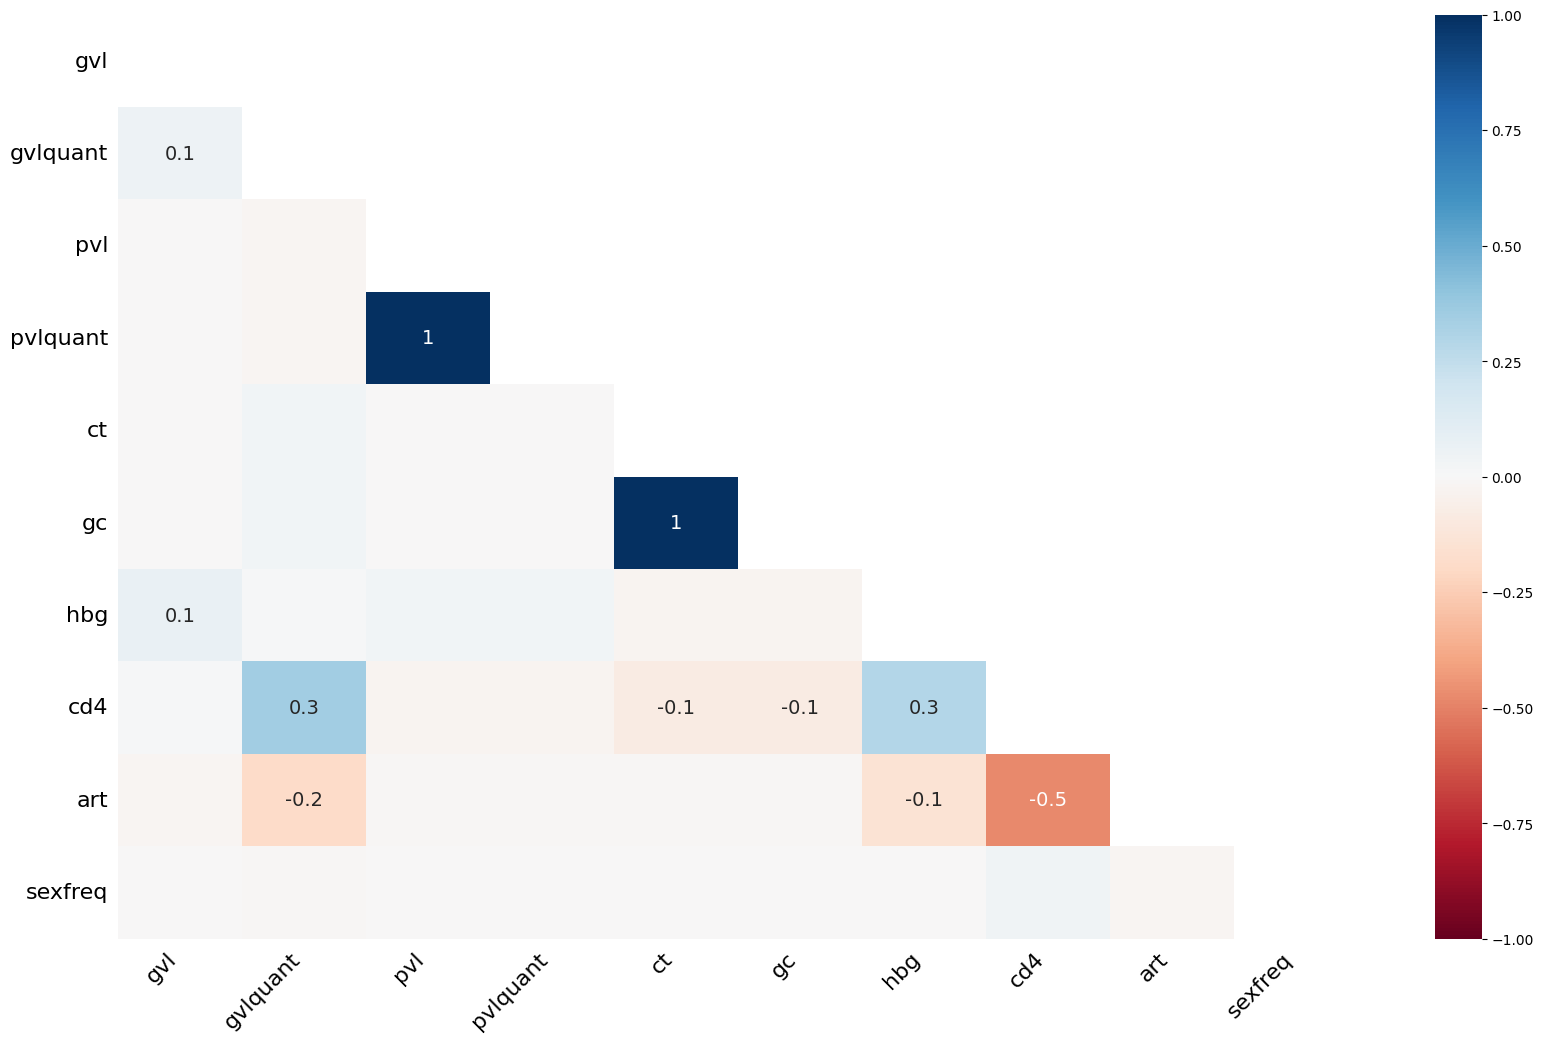

In [5]:
msno.heatmap(df)

The graph above is a heatmap generated by the msno.heatmap function. This visualization shows the correlation of missing values ​​between different variables in the dataset. The color scale, which ranges from dark blue to burgundy, indicates the strength and direction of the correlation. Dark blue squares suggest a positive correlation, meaning that when one variable is missing, the other is likely to be missing as well. Light blue or white squares indicate little or no correlation between missing variables. From the heatmap, you can draw conclusions about the relationship between missing values ​​in different variables. For example, if two variables have a strong positive correlation in terms of missing values, this could suggest that the causes of missing values ​​are related or that both variables share a common data collection problem. Conversely, no correlation could mean that missing values ​​are not related between variables. From the visualization, it can be concluded that missing data on plasma viral load are strongly correlated with a binary variable indicating whether the load is detectable. Missing information on the occurrence of gonorrhea and chlamydia is also strongly correlated.

## Diagnostics 

In the analyzed dataset, it was observed that some variables, although rarely, were missing values. This sporadic pattern of missing values, combined with an understanding of the data collection process, contributed to the decision to assign zeros to missing values. In particular, I identified missing entries in the columns "art", "sexfreq", "pvl", "ct", "gc", and "glv". A deeper analysis of the data revealed a specific pattern for the variables "gvlquant" and "pvlquant". I noticed that missing values ​​for these variables only occur when the corresponding values ​​of "glv" and "pvl" are zero. This consistent pattern prompted further analysis of the dataset, which revealed that when “glv” and “pvl” are zero, “gvlquant” and “pvlquant” have values ​​of 20. Using this knowledge, I assigned missing values ​​for “gvlquant” and “pvlquant” a value of 20.
This imputation strategy relies on observed patterns in the data and the context provided by the data collection methodology. The “hbg” and “cp4” columns required more detailed analysis to select an imputation method. The first step was to diagnose patterns of missing data.
Understanding whether data are missing not at random (MNAR), completely at random (MCAR), or missing at random (MAR) is fundamental to statistical analysis and data science because it directly affects how missing data are handled and the significance of subsequent analysis and conclusions (Little & Rubin, 2002) (Molenberghs & Kenward, 2007).
In the case of MCAR, the missingness is unrelated to any values, observed or unobserved. This is a favorable scenario because it means that the missing data are just a random subset of the data. Statistical analyses assume that MCAR can proceed without bias because the missing data are representative of the complete data. In the case of MAR, the missingness is related to the observed data but not to the missing data. This means that the missing values ​​can be predicted from other variables that are not missing. Many statistical techniques and imputation methods are designed to handle MAR data by using the observed data to estimate the missing values. This allows for meaningful inferences to be made as long as the relationship between the observed data and the missingness is properly accounted for. In the case of MNAR, however, the missingness is related to the unobserved values ​​themselves. This is the most challenging scenario because it can introduce significant bias into the analysis. The missing values ​​are not missing at random, and any patterns in the missing data are related to the missing information. Specialized statistical methods must be used to process MNAR data, and additional information or assumptions are often required to draw valid conclusions.
Understanding the mechanism behind missing data is crucial because it affects the choice of imputation method and the interpretation of results. Incorrect assumptions about the mechanism of missing data can lead to biased parameter estimates, erroneous conclusions, and poor decision-making. Therefore, before performing any data analysis, it is important to assess the pattern and mechanism of missing data in order to apply the most appropriate imputation techniques.
In the process of diagnosing what pattern of missingness there is in my data, I decided to first use Little’s MCAR test (Little, 1988). This is a statistical procedure used to test the null hypothesis that missing data in a data set are missing completely at random (MCAR).
The test compares the observed patterns of missingness with what would be expected if the missing data were missing completely at random. This is done by examining the covariance matrix of the variables with missing data and comparing it with the covariance matrix that would be expected if the data were MCAR. The test statistic used is the chi-square statistic, which measures the discrepancy between the observed and expected covariance matrices. If the p-value of the test is less than the chosen significance level (usually 0.05), I reject the null hypothesis, indicating that we are not dealing with a case of MCAR. This suggests that the missing data is either a case of MAR (missing at random, where missing is associated with the observed data but not with the missing data itself) or MNAR. The method I chose to perform Little's test in python uses the pyampute library (Schouten, et al., 2021). The MCARTest class from the pyampute.exploration.mcar_statistical_tests module is used to perform a test on a data set to determine whether the missing data is completely missing at random (MCAR). The result of the test is a p-value, which is used to determine whether the null hypothesis (that the data is MCAR) can be rejected. A p-value of 0.0 suggests that there is a statistically significant pattern of missing data, and therefore the null hypothesis of MCAR can be rejected. This indicates that the missing data in the data set is not completely random and may be related to the observed data (MAR) or the missing data itself (MNAR), which can be determined to some extent by the chi-square test, and the conclusion from this analysis is that for those predictor variables for which the p-value in the chi-square test is less than 0.05, the null hypothesis of independence can be rejected. This indicates that there is a statistically significant association between the missing of “hbg” and “cp4” and the other predictor variables. The presence of such significant p-values ​​suggests that the missing pattern of data for “hbg” and “cp4” is not completely random (MNAR). Instead, it is likely that the missing data is related to other variables in the data set, indicating a missing at random (MAR) pattern.

In [6]:
mcar_test = MCARTest(method='little')
p_value = mcar_test.little_mcar_test(df)

print(f'P-value w teście Littles MCAR: {p_value}')

P-value w teście Littles MCAR: 0.0


In [7]:
missing_df = df.copy()

missing_df['hbg_missing'] = missing_df['hbg'].isna().astype(int)
predictors = [col for col in missing_df.columns if col not in ['hbg', 'hbg_missing']]

for var in predictors:
    contingency_table = pd.crosstab(missing_df[var], missing_df['hbg_missing'])
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-square test for {var}: p-value = {p_val:.4f}")

Chi-square test for PID: p-value = 0.8466
Chi-square test for arm: p-value = 0.9106
Chi-square test for gvl: p-value = 0.9328
Chi-square test for gvlquant: p-value = 0.5084
Chi-square test for pvl: p-value = 0.4957
Chi-square test for pvlquant: p-value = 0.6891
Chi-square test for trich: p-value = 0.8034
Chi-square test for bv: p-value = 0.0570
Chi-square test for sy: p-value = 0.4250
Chi-square test for ct: p-value = 0.1912
Chi-square test for gc: p-value = 0.7916
Chi-square test for cd4: p-value = 1.0000
Chi-square test for art: p-value = 0.0098
Chi-square test for artgroup: p-value = 0.7664
Chi-square test for age: p-value = 1.0000
Chi-square test for education: p-value = 0.6484
Chi-square test for employed: p-value = 1.0000
Chi-square test for gravid: p-value = 0.9996
Chi-square test for everpreg: p-value = 0.9292
Chi-square test for sexparts: p-value = 0.8431
Chi-square test for sexfreq: p-value = 0.9904
Chi-square test for iud_reason_Wants pregnancy: p-value = 1.0000
Chi-square t

In [8]:
missing_df['cd4_missing'] = missing_df['cd4'].isna().astype(int)
predictors = [col for col in missing_df.columns if col not in ['cd4', 'cd4_missing']]

for var in predictors:
    contingency_table = pd.crosstab(missing_df[var], missing_df['cd4_missing'])
    chi2, p_val, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-square test for {var}: p-value = {p_val:.4f}")

Chi-square test for PID: p-value = 0.7271
Chi-square test for arm: p-value = 0.3437
Chi-square test for gvl: p-value = 0.0000
Chi-square test for gvlquant: p-value = 0.4206
Chi-square test for pvl: p-value = 0.0000
Chi-square test for pvlquant: p-value = 0.0000
Chi-square test for trich: p-value = 0.3399
Chi-square test for bv: p-value = 0.3405
Chi-square test for sy: p-value = 0.5783
Chi-square test for ct: p-value = 0.4905
Chi-square test for gc: p-value = 0.5117
Chi-square test for hbg: p-value = 0.2338
Chi-square test for art: p-value = 0.0000
Chi-square test for artgroup: p-value = 0.0000
Chi-square test for age: p-value = 0.0000
Chi-square test for education: p-value = 0.4005
Chi-square test for employed: p-value = 0.0195
Chi-square test for gravid: p-value = 0.0002
Chi-square test for everpreg: p-value = 0.8261
Chi-square test for sexparts: p-value = 0.1403
Chi-square test for sexfreq: p-value = 0.0510
Chi-square test for iud_reason_Wants pregnancy: p-value = 0.1309
Chi-square t